Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy

USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [2]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)), 
                v2.RandomRotation(degrees=10)]

transform = v2.Compose([
                v2.ToImage(), 
                v2.ToDtype(torch.float32, scale=True),
                v2.RandomApply(random_trans)
                # v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1)),
                # v2.RandomChannelPermutation(),
                # v2.Normalize((0.2382, 0.2426, 0.2483), (0.3126, 0.3170, 0.3241))
                ])

In [3]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [4]:
# creat a dictionary that maps index to label
data_dir='ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [5]:
button_train = CropButtonDataset('ClassificationDataset_label/train', transform=transform)
loader_train = DataLoader(button_train, batch_size=64, shuffle=True)

button_val = CropButtonDataset('ClassificationDataset_label/val', transform=transform)
loader_val = DataLoader(button_val, batch_size=14, shuffle=True)

button_test = CropButtonDataset('ClassificationDataset_label/test', transform=transform)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [6]:
loader_train

In [7]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([14, 3, 320, 320])
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1])


Load pre-trained model and check output shape

In [8]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open('ClassificationDataset_label/train/left/4ebee0cf-69805b37-20250502_173224_0_class0.jpg')

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base', use_fast=True)
dino = AutoModel.from_pretrained('facebook/dinov2-base')

inputs = processor(images=image, return_tensors="pt")
outputs = dino(**inputs)
last_hidden_states = outputs.last_hidden_state

In [9]:
print(last_hidden_states.shape)

torch.Size([1, 257, 768])


Model setup

In [ ]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone_name='facebook/dinov2-base'):
        super().__init__()
        self.processor = AutoImageProcessor.from_pretrained(backbone_name, use_fast=True)
        self.backbone = AutoModel.from_pretrained(backbone_name)

        # freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        hidden_dim = self.backbone.config.hidden_size

        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 1)
        )

    # CLS + Mean pooling
    def forward(self, x_tensor):  # x_tensor: Tensor, shape [B, 3, H, W]
        # inputs = self.processor(images=x_tensor, return_tensors="pt") 
        # inputs = {k: v.to(x_tensor.device) for k, v in inputs.items()}

        # outputs = self.backbone(**inputs)
        # last_hidden = outputs.last_hidden_state  

        # cls_token = last_hidden[:, 0, :]             
        # mean_pool = last_hidden[:, 1:, :].mean(dim=1) 

        # fusion = torch.cat([cls_token, mean_pool], dim=-1) 

        # 1. Preprocess image
        inputs = self.processor(images=x_tensor, return_tensors="pt")
        inputs = {k: v.to(x_tensor.device) for k, v in inputs.items()}

        # 2. Backbone forward
        with torch.no_grad():
            outputs = self.backbone(**inputs)
        last_hidden = outputs.last_hidden_state  # (B, N+1, D)

        # 3. Multi-head attention on patch + CLS tokens
        attn_out, _ = self.attn(last_hidden, last_hidden, last_hidden)  # shape: (B, N+1, D)
        attn_out = self.norm(attn_out)

        # 4. Use [CLS] token only
        cls_token = attn_out[:, 0, :]  # (B, D)

        # 5. Classifier
        logits = self.classifier(cls_token)
        return logits
        # return self.classifier(fusion)  

    
model = DinoClassifier()
model = model.to(device)

In [31]:
# check freeze
for name, param in model.named_parameters():
    # if not freeze
    if (param.requires_grad):
        print(name)

classifier.0.weight
classifier.0.bias
classifier.1.weight
classifier.1.bias
classifier.2.weight
classifier.2.bias
classifier.5.weight
classifier.5.bias
classifier.6.weight
classifier.6.bias
classifier.9.weight
classifier.9.bias


In [18]:
def check_accuracy_final(loader, model, out=False):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)
            scores = model(x)
            preds = (torch.sigmoid(scores) > 0.5).long()

            if out:
                print("Sample preds:", torch.sigmoid(scores).flatten().tolist())
                print("Sample labels:", y.flatten().tolist())
            
            num_correct += (preds == y.long()).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

In [19]:
def train(model, optimizer, epochs=10, opt=False):
    x1 = list(range(len(loader_train) * epochs))
    y1 = []
    y2 = []
    y3 = []
    model = model.to(device=device)
    criterion = nn.BCEWithLogitsLoss()
    cnt = 1
    total_cnt = epochs * len(loader_train)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=dtype).unsqueeze(1)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y1.append(loss.item())
            acc_val = check_accuracy_final(loader_val, model, out=opt)
            acc_train = check_accuracy_final(loader_train, model, out=opt)
            y2.append(acc_val)
            y3.append(check_accuracy_final(loader_train, model))
            print("iteration: " +  str(cnt) + "/" + str(total_cnt) + "   loss = " + str(loss.item()) + 
                  "   train_acc = " + str(acc_train) + "   val_acc = " + str(acc_val) )

            cnt += 1
    return (x1, y1, y2, y3)

def plotpic(data):
    x, y1, y2, y3 = data
    plt.figure()
    plt.plot(x, y1, marker='.')
    plt.xlabel('Iteratoin')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.grid(True)

    plt.figure()
    plt.plot(x, y2, marker='o', label='Validation Accuracy')
    plt.plot(x, y3, marker='o', label='Training Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [20]:
# criterion = nn.BCEWithLogitsLoss()
# sgdMNb = optim.SGD(model.parameters(), lr=1e-2, momentum=0.8, nesterov=True)
# adamw = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)

Find best hyperparameter

In [24]:
def hyperparameter_search(DinoClassifier, loader_train, loader_val, device, epochs=3, opt=False):
    lr_list = 10 ** np.random.uniform(-2, -6, (10,))
    wd_list = 10 ** np.random.uniform(-2, -4, (5,))
    beta_list = [(0.85, 0.99), (0.85, 0.995), (0.9, 0.98), (0.9, 0.99), (0.9, 0.995), (0.9, 0.999),
    (0.95, 0.98), (0.95, 0.99), (0.95, 0.995), (0.95, 0.999)]

    best_acc = 0.0
    best_model = None
    best_params = {}
    
    for lr, wd, betas in itertools.product(lr_list, wd_list, beta_list):
        print(f"\n🔧 Testing AdamW: lr={lr}, wd={wd}, betas={betas}")
        
        model = DinoClassifier().to(device)
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr,
            weight_decay=wd,
            betas=betas
        )

        data = train(model, optimizer, epochs=epochs, opt=opt)
        _, _, val_accs, _ = data

        final_val_acc = val_accs[-1]
        print(f"Final val acc for lr={lr}, wd={wd}: {final_val_acc:.4f}")

        if final_val_acc > best_acc:
            best_acc = final_val_acc
            best_params = {"lr": lr, "weight_decay": wd}
            best_model = deepcopy(model)
            best_training_data = data

    print("\n Best Hyperparameters:")
    print(best_params)
    print(f"Best val acc: {best_acc:.4f}")

    # save model
    torch.save(best_model.state_dict(), "best_dino_model.pt")
    print(" Saved best model to best_dino_model.pt")

    return best_model, best_params, best_training_data


In [25]:
best_model, best_params, best_training_data = hyperparameter_search(DinoClassifier, loader_train, loader_val, device, opt=False)


🔧 Testing AdamW: lr=1.515914167041141e-06, wd=0.0004609389889268166, betas=(0.85, 0.99)
iteration: 1/9   loss = 0.7170377969741821   train_acc = 0.48507462686567165   val_acc = 0.5
iteration: 2/9   loss = 0.6934084892272949   train_acc = 0.4701492537313433   val_acc = 0.5714285714285714
iteration: 3/9   loss = 0.7131143808364868   train_acc = 0.5   val_acc = 0.6428571428571429
iteration: 4/9   loss = 0.78199303150177   train_acc = 0.4925373134328358   val_acc = 0.6428571428571429
iteration: 5/9   loss = 0.6965426206588745   train_acc = 0.47761194029850745   val_acc = 0.5714285714285714
iteration: 6/9   loss = 0.8168330192565918   train_acc = 0.48507462686567165   val_acc = 0.5714285714285714
iteration: 7/9   loss = 0.7336984276771545   train_acc = 0.4925373134328358   val_acc = 0.6428571428571429
iteration: 8/9   loss = 0.7498762011528015   train_acc = 0.4925373134328358   val_acc = 0.6428571428571429
iteration: 9/9   loss = 0.810998797416687   train_acc = 0.4701492537313433   val_acc

In [27]:
check_accuracy_final(loader_test, best_model, True)

Sample preds: [0.5196051597595215, 0.5701690912246704, 0.45812299847602844, 0.46519896388053894, 0.5586340427398682, 0.46486222743988037, 0.594819188117981, 0.40599325299263, 0.5451045036315918, 0.4947015047073364, 0.5711573362350464, 0.5781726837158203, 0.5510219931602478, 0.5724083185195923]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.5714285714285714

Train best model

In [32]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
            lr=1.515914167041141e-06,
            weight_decay=0.0002300292096821906,
            betas=(0.9, 0.995))

data = train(model, optimizer, epochs=50)

iteration: 1/150   loss = 0.7057721018791199   train_acc = 0.5074626865671642   val_acc = 0.5714285714285714
iteration: 2/150   loss = 0.7178230285644531   train_acc = 0.5149253731343284   val_acc = 0.5714285714285714
iteration: 3/150   loss = 0.8218382596969604   train_acc = 0.5074626865671642   val_acc = 0.5
iteration: 4/150   loss = 0.7563289403915405   train_acc = 0.5   val_acc = 0.5714285714285714
iteration: 5/150   loss = 0.6881057024002075   train_acc = 0.5223880597014925   val_acc = 0.5
iteration: 6/150   loss = 0.6377691626548767   train_acc = 0.5074626865671642   val_acc = 0.5714285714285714
iteration: 7/150   loss = 0.7016010284423828   train_acc = 0.5223880597014925   val_acc = 0.5
iteration: 8/150   loss = 0.7544953227043152   train_acc = 0.4925373134328358   val_acc = 0.5
iteration: 9/150   loss = 0.604245126247406   train_acc = 0.5   val_acc = 0.5714285714285714
iteration: 10/150   loss = 0.7466095685958862   train_acc = 0.5149253731343284   val_acc = 0.5714285714285714


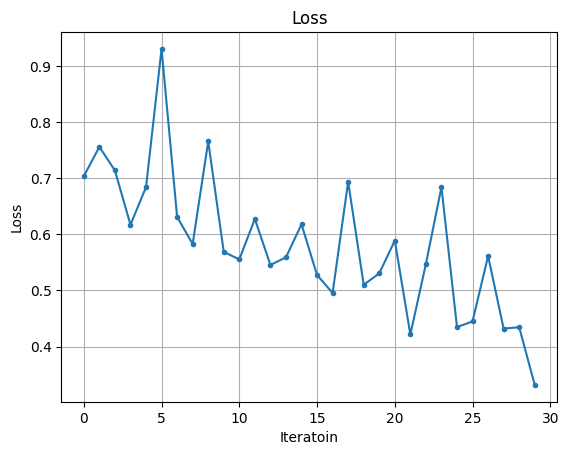

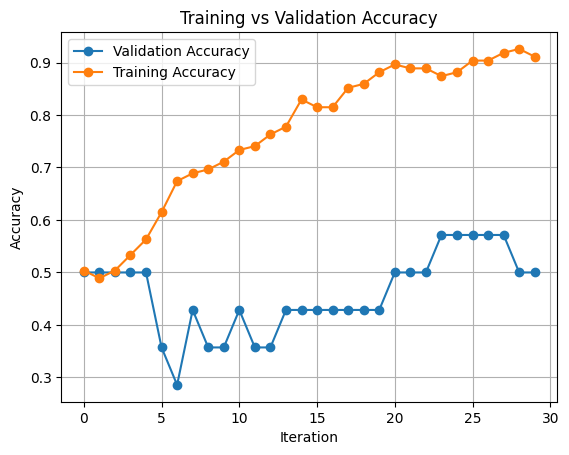

In [ ]:
plotpic(data)